# K-Means and the UCI Wholesale Customer Data Set
### Kevin Maher
### <span style="color:blue">Vettejeep365@gmail.com</span>

Imports needed for the script.  Uses Python 2.7.13, numpy 1.11.3, pandas 0.19.2, sklearn 0.18.1, scipy 0.18.1, matplotlib 2.0.0.

In [121]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

Read in the data, it is from the UCI Wholesale Customer Dataset at:
https://archive.ics.uci.edu/ml/datasets/wholesale+customers.

In [122]:
df = pd.read_csv('Wholesale customers data.csv')

Create a feature for total customer size. Note: 'Delicassen' misspelled in original data file.

In [123]:
df['Total'] = df['Fresh'] + df['Milk'] + df['Grocery'] + df['Frozen'] + df['Detergents_Paper'] + df['Delicassen']
print df.head()

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669  9656     7561     214              2674   
1        2       3   7057  9810     9568    1762              3293   
2        2       3   6353  8808     7684    2405              3516   
3        1       3  13265  1196     4221    6404               507   
4        2       3  22615  5410     7198    3915              1777   

   Delicassen  Total  
0        1338  34112  
1        1776  33266  
2        7844  36610  
3        1788  27381  
4        5185  46100  


Add a function to convert and join dummy variables to the model.  If source df = dest df then remember to delete the original catagorical variable.

In [124]:
def get_dummies(source_df, dest_df, col):
    dummies = pd.get_dummies(source_df[col], prefix=col)

    print 'Quantities for %s column' % col
    for col in dummies:
        print '%s: %d' % (col, np.sum(dummies[col]))
    print

    dest_df = dest_df.join(dummies)
    return dest_df

Process dummy variables for the 'Channel' and 'Region' features.  Drop original categorical feature, plus drop one of the dummy variables for 'leave one out' encoding. 

In [125]:
df = get_dummies(df, df, 'Channel')
df.drop(['Channel', 'Channel_2'], axis=1, inplace=True)
df = get_dummies(df, df, 'Region')
df.drop(['Region', 'Region_3'], axis=1, inplace=True)
df.rename(index=str, columns={'Channel_1': 'Channel_Horeca', 'Region_1': 'Region_Lisbon', 'Region_2': 'Region_Oporto'},
                              inplace=True)
print df.head()

Quantities for Channel column
Channel_1: 298
Channel_2: 142

Quantities for Region column
Region_1: 77
Region_2: 47
Region_3: 316

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  Total  \
0  12669  9656     7561     214              2674        1338  34112   
1   7057  9810     9568    1762              3293        1776  33266   
2   6353  8808     7684    2405              3516        7844  36610   
3  13265  1196     4221    6404               507        1788  27381   
4  22615  5410     7198    3915              1777        5185  46100   

   Channel_Horeca  Region_Lisbon  Region_Oporto  
0               0              0              0  
1               0              0              0  
2               0              0              0  
3               1              0              0  
4               0              0              0  


Plot a histogram of customer size, shows a small number of large customers, many smaller customers.

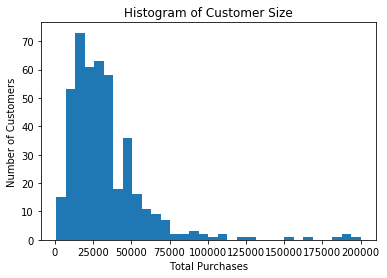

In [126]:
plt.hist(df['Total'], bins=32)
plt.xlabel('Total Purchases')
plt.ylabel('Number of Customers')
plt.title('Histogram of Customer Size')
plt.show()
plt.close()

Scale the data so no category dominates due to numeric scale.

In [127]:
sc = StandardScaler()
sc.fit(df)
X = sc.transform(df)

Set up a plotting function for K Means output.

In [128]:
def plot_kmeans(pred, centroids, x_name, y_name, x_idx, y_idx, k):
    for i in range(0, k):
        plt.scatter(df[x_name].loc[pred == i], df[y_name].loc[pred == i], s=6,
                    c=colors[i], marker=markers[i], label='Cluster %d' % (i + 1))

    centroids = sc.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, x_idx], centroids[:, y_idx],
                marker='x', s=180, linewidths=3,
                color='k', zorder=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()
    plt.close()

Set up some markers and colors.

In [129]:
markers = ('s', 'o', 'v', '*', 'D', '+', 'p', '<', '>', 'x')
colors = ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9')

Try K Means with k = 3 (Mainly because when I previously studied this using R, 3 produced interesting results).  The value for 'k' will be set from a distortion graph later in the notebook.

In [130]:
k=3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
pred = kmeans.predict(X)

for i in range(0, k):
    x = len(pred[pred == i])
    print 'Cluster %d has %d members' % ((i + 1), x)

Cluster 1 has 296 members
Cluster 2 has 131 members
Cluster 3 has 13 members


Use an inverse transform on the centroids.  Needed because the centroids were calculated on the scaled data and we would like the centroids to plot correctly with the original data.

In [131]:
centroids = sc.inverse_transform(kmeans.cluster_centers_)

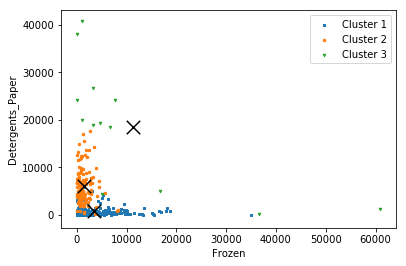

In [132]:
plot_kmeans(pred, centroids, 'Frozen', 'Detergents_Paper', 3, 4, k)

Commentary: The presence of a few large customers makes plot with more clusters hard to interpret because the mass of smaller customers is pushed into the lower right corner of the graph above.  Though large customer behavior is interesting, especially in a business setting, here I will focus on smaller customers.  A look at the histogram above appears to make a total sales level of 75,000 euros a reasonable break point.  As an aside, when I tried this in R, the K Means algorithm tended to produce two large customer clusters and one for the great mass of smaller customers.  The plot above was chosen because it is representative of a pattern in the data - namely that there are customers who buy one type of product from our wholesale client but do not buy other types of products.  Keeping this Jupyter notebook to a reasonable size precludes showing all possible combinations of product pairs as graphs here.  

Set up the data structures for the smaller customers.  We need to rescale the data because of the elimination of larger customers.

In [133]:
df = df.loc[df['Total'] <= 75000]

sc = StandardScaler()
sc.fit(df)
X = sc.transform(df)

Plot a distortion or elbow graph to help chose an optimal value for k.

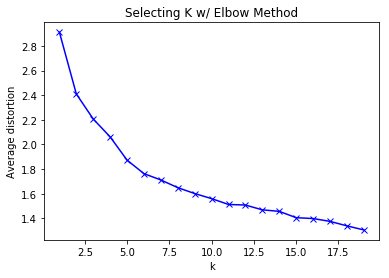

In [134]:
K = range(1, 20)
mean_distortions = []
for k in K:
    np.random.seed(555)
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    mean_distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis = 1))/ X.shape[0])

plt.plot(K, mean_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting K w/ Elbow Method')
plt.show()
plt.close()

Distortion plots often have elbow points that are difficult to interpret, but k = 6 looks like it might make for an interesting set of clusters and plots.

In [135]:
np.random.seed(555)  # sets seed, makes it repeatable
k = 6
kmeans = KMeans(n_clusters=k)  # , init='random')
kmeans.fit(X)
pred = kmeans.predict(X)

for i in range(0, k):
    x = len(pred[pred == i])
    print 'Cluster %d has %d members' % ((i + 1), x)

Cluster 1 has 60 members
Cluster 2 has 153 members
Cluster 3 has 39 members
Cluster 4 has 53 members
Cluster 5 has 78 members
Cluster 6 has 37 members


Plot K Means result with centroids.

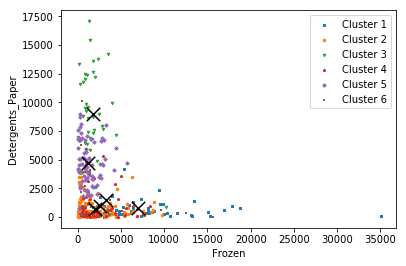

In [136]:
centroids = sc.inverse_transform(kmeans.cluster_centers_)
plot_kmeans(pred, centroids, 'Frozen', 'Detergents_Paper', 3, 4, k)

The pattern seen in the full data set also shows up amongst the set of customers with less than 75,000 euros in total sales. There are, for example, a number of customers who buy detergents and paper from our client but not frozen goods, the inverse also appears to be true.  A business domain expert could be consulted in order to try and determine if this is charasteristic of the needs of these customers or perhaps there are missed opportunities for our client's marketing department.

The pattern noted is especially apparent in clusters 1, 3 and 5; lets see what we can learn about these clusters.

A function to print cluster data.

In [137]:
def print_cluster_data(cluster_number):
    print '\nData for cluster %d' % cluster_number
    cluster = df.loc[pred == cluster_number - 1, :]
    # print cluster1.head()
    num_in_cluster = float(len(cluster.index))
    num_horeca = float(np.sum(cluster['Channel_Horeca']))
    num_retail = float(num_in_cluster - num_horeca)
    print 'Percent Horeca: %.2f, Percent Retail: %.2f' % \
          (num_horeca / num_in_cluster * 100.0, num_retail / num_in_cluster * 100.0)

    num_lisbon = float(np.sum(cluster['Region_Lisbon']))
    num_oporto = float(np.sum(cluster['Region_Oporto']))
    num_other = num_in_cluster - num_lisbon - num_oporto
    print 'Percent Lisbon: %.2f, Percent Oporto: %.2f, Percent Other: %.2f' % \
          (num_lisbon / num_in_cluster * 100.0, num_oporto / num_in_cluster * 100.0, num_other / num_in_cluster * 100.0)

    avg_cust_size = np.sum(cluster['Total']) / num_in_cluster
    print 'Average Customer Size is: %.2f for %d Customers' % (avg_cust_size, num_in_cluster)

Print out data for clusters 1, 3 and 5.

In [138]:
print_cluster_data(cluster_number=1)
print_cluster_data(cluster_number=3)
print_cluster_data(cluster_number=5)


Data for cluster 1
Percent Horeca: 93.33, Percent Retail: 6.67
Percent Lisbon: 11.67, Percent Oporto: 0.00, Percent Other: 88.33
Average Customer Size is: 47384.95 for 60 Customers

Data for cluster 3
Percent Horeca: 7.69, Percent Retail: 92.31
Percent Lisbon: 23.08, Percent Oporto: 20.51, Percent Other: 56.41
Average Customer Size is: 52915.13 for 39 Customers

Data for cluster 5
Percent Horeca: 3.85, Percent Retail: 96.15
Percent Lisbon: 7.69, Percent Oporto: 0.00, Percent Other: 92.31
Average Customer Size is: 33858.73 for 78 Customers


Commentary: clusters 3 and 5 are dominated by retail customers, in an actual business setting we might want to investigate why they buy lots of detergents and paper from our client but not much in the way of frozen goods.  Cluster 1 represents customers from the "Horeca" (hotel, restaurant, cafe) distribution channel.  These customers tend to buy frozen goods but not detergents and paper, perhaps because they sell food and only use detergents and paper as maintenance supplies.  Clustering can help in a marketing segmentation analysis by identifying types and groups of customers.  

I hope that you have enjoyed my example of using Python and K Means to identify some of the patterns in the UCI Wholesale Customers data set.